# Assignment

## Instructions

In this assignment, you will apply the computer vision concepts covered in the lesson to perform image classification using the Fashion MNIST dataset. The Fashion MNIST dataset consists of 60,000 28x28 grayscale images of 10 fashion categories.

### Task: Build an Image Classifier

1. Use the provided starter code to load and explore the Fashion MNIST dataset
2. Preprocess the images using appropriate techniques (e.g., normalization, data augmentation)
3. Build a CNN model to classify the images into one of the 10 classes
4. Train your model and evaluate its performance
5. Experiment with at least one technique to improve model performance (e.g., batch normalization, different pooling strategies, additional convolutional layers)
6. Visualize and analyze your results

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Classes in Fashion MNIST
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


In [10]:
# Display after load: dataset sizes and sample training images
print(f'Training set size: {len(train_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 60000
Test set size: 10000


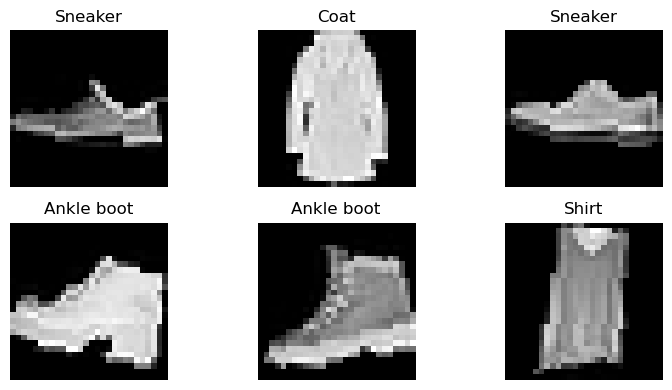

In [11]:
#explore the dataset
# Visualize some training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(8, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
# Helper Functions
def train_model(model, train_loader, criterion, optimizer, scheduler=None, epochs=10):
    """Train a model and return training history"""
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

        if scheduler:
            scheduler.step()

    return train_losses

def evaluate_model(model, test_loader):
    """Evaluate model and return accuracy"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [13]:
# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
         # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 28x28 → 14x14
        x = self.pool(F.relu(self.conv2(x)))   # 14x14 → 7x7
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [15]:
# Train Basic CNN
print("Training Basic CNN...")

cnn1_model = FashionCNN().to(device)
cnn1_criterion = nn.CrossEntropyLoss()
cnn1_optimizer = optim.Adam(cnn1_model.parameters(), lr=0.003)

cnn1_losses = train_model(cnn1_model, train_loader, cnn1_criterion, cnn1_optimizer)
cnn1_accuracy = evaluate_model(cnn1_model, test_loader)
print(f'Basic CNN Accuracy: {cnn1_accuracy:.2f}%\n')

Training Basic CNN...
Epoch 1/10, Loss: 0.4684
Epoch 2/10, Loss: 0.3422
Epoch 3/10, Loss: 0.3075
Epoch 4/10, Loss: 0.2927
Epoch 5/10, Loss: 0.2790
Epoch 6/10, Loss: 0.2716
Epoch 7/10, Loss: 0.2642
Epoch 8/10, Loss: 0.2589
Epoch 9/10, Loss: 0.2539
Epoch 10/10, Loss: 0.2493
Basic CNN Accuracy: 90.43%



In [16]:
#Improve the model
# Add in batch normalization and increase dropout
class RegularizedCNN(nn.Module):
    def __init__(self):
        super(RegularizedCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28→14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14→7
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 7→3
        
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [19]:
# Train Regularized CNN
print("Training CNN with BatchNorm and Dropout...")
cnn2_model = RegularizedCNN().to(device)
cnn2_criterion = nn.CrossEntropyLoss()
cnn2_optimizer = optim.Adam(cnn2_model.parameters(), lr=0.001)

cnn2_losses = train_model(cnn2_model, train_loader, cnn2_criterion, cnn2_optimizer)
cnn2_accuracy = evaluate_model(cnn2_model, test_loader)
print(f'Regularized CNN Accuracy: {cnn2_accuracy:.2f}%\n')

Training CNN with BatchNorm and Dropout...
Epoch 1/10, Loss: 0.4584
Epoch 2/10, Loss: 0.3247
Epoch 3/10, Loss: 0.2863
Epoch 4/10, Loss: 0.2611
Epoch 5/10, Loss: 0.2458
Epoch 6/10, Loss: 0.2317
Epoch 7/10, Loss: 0.2218
Epoch 8/10, Loss: 0.2115
Epoch 9/10, Loss: 0.2028
Epoch 10/10, Loss: 0.1931
Regularized CNN Accuracy: 91.26%



Analysis: 
1) BatchNorm
- Stabilizes learning
- Allows higher learning rate
- Reduces internal covariate shift

2) Extra Conv Layer
- Learns higher-level features
- Better pattern abstraction

3) Dropout
- Reduces overfitting
- Encourages generalization